In [1]:
import time
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from functools import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import re
from sklearn.ensemble import GradientBoostingClassifier
#from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [6]:
df = pd.read_csv('sparse.csv')

In [3]:
df.head(5)

,id,keyword,location,text,target,Sentiment_Score
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.166410
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,-0.051031
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.015811
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,-0.188982
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,-0.062500


In [4]:
df['length'] = np.array(list(map(len, df['text'])))

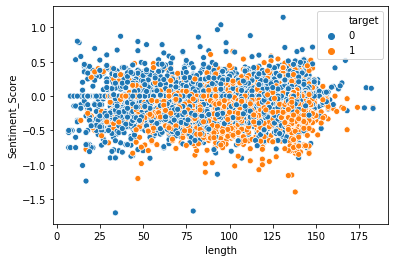

In [42]:
sns.scatterplot(x='length', y='Sentiment_Score', hue='target', data=df)

In [50]:
tdm_lab = tdm_simple.copy()
tdm_lab['_length'] = df['length']
tdm_lab['_sentiment'] = df['Sentiment_Score']
tdm_lab['_target'] = df['target']

In [76]:
np.random.seed(1)
train, test = train_test_split(tdm_lab, test_size=0.25)
train_x = train.drop('_target', axis=1)
train_y = train['_target']
test_x = test.drop('_target', axis=1)
test_y = test['_target']

In [77]:
rft = RandomForestClassifier(n_estimators=500, oob_score=True, verbose=1)
rft.fit(train_x, train_y)
print('OOB estimate:', rft.oob_score_)
preds = rft.predict(test_x)
rft_cm = confusion_matrix(test_y, preds)
print(rft_cm)
tp, fn, fp, tn = rft_cm.ravel()
accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
F = 2*precision*recall/(precision + recall)
print('Accuracy: {:.3f}%\nPrecision: {:.3f}%\nRecall: {:.3f}%\nF: {:.3f}'.format(accuracy, precision, recall, F))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.5min finished


OOB estimate: 0.7866526537046769


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[1011   80]
 [ 326  487]]
Accuracy: 0.787%
Precision: 0.756%
Recall: 0.927%
F: 0.833


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [ ]:
# After adding sentiment scores and length:
# Not stratified, no filter, 25%: 83.3
# Stratified, no filter, 25%:     82.7

In [78]:
# Adding the sentiment scores and length of text did not improve the random forest model.
df_final['_length'] = df['length']
df_final['_sentiment'] = df['Sentiment_Score']

In [83]:
np.random.seed(1)
train, test = train_test_split(df_final, test_size=0.25)
train_x = train.drop('_target', axis=1)
train_y = train['_target']
test_x = test.drop('_target', axis=1)
test_y = test['_target']

In [84]:
rft2 = RandomForestClassifier(n_estimators=500, oob_score=True, verbose=1)
rft2.fit(train_x, train_y)
print('OOB estimate:', rft2.oob_score_)
preds2 = rft2.predict(test_x)
rft2_cm = confusion_matrix(test_y, preds2)
print(rft2_cm)
tp2, fn2, fp2, tn2 = rft2_cm.ravel()
accuracy2 = (tp2+tn2)/(tp2+fn2+fp2+tn2)
precision2 = tp2/(tp2 + fp2)
recall2 = tp2/(tp2 + fn2)
F2 = 2*precision2*recall2/(precision2 + recall2)
print('Accuracy: {:.3f}%\nPrecision: {:.3f}%\nRecall: {:.3f}%\nF: {:.3f}'.format(accuracy2, precision2, recall2, F2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.7min finished


OOB estimate: 0.791382028376248


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[969 122]
 [299 514]]
Accuracy: 0.779%
Precision: 0.764%
Recall: 0.888%
F: 0.822


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.8s finished


In [ ]:
# Not stratified, filtered: 82.2
# Stratified, filtered:     82.5

In [92]:
np.random.seed(1)
train, test = train_test_split(tdm_lab, test_size=0.1)
train_x = train.drop('_target', axis=1)
train_y = train['_target']
test_x = test.drop('_target', axis=1)
test_y = test['_target']

In [93]:
# Gradient boosting classifier
# Lots of parameters, but let's just see how the default does first...
gbc = GradientBoostingClassifier(learning_rate=0.25, n_estimators=1000, max_depth=5, verbose=1)
gbc.fit(train_x, train_y)
preds = gbc.predict(test_x)
gbc_cm = confusion_matrix(test_y, preds)
print(gbc_cm)
tp, fn, fp, tn = gbc_cm.ravel()
accuracy = (tp+tn)/(tp+fn+fp+tn)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
F = 2*precision*recall/(precision + recall)
print('Accuracy: {:.3f}%\nPrecision: {:.3f}%\nRecall: {:.3f}%\nF: {:.3f}'.format(accuracy, precision, recall, F))

      Iter       Train Loss   Remaining Time 
         1           1.2932           30.55m
         2           1.2373           33.68m
         3           1.1949           33.42m
         4           1.1652           32.68m
         5           1.1407           32.67m
         6           1.1205           30.46m
         7           1.1042           29.57m
         8           1.0905           28.24m
         9           1.0771           26.82m
        10           1.0635           26.42m
        20           0.9727           22.15m
        30           0.9143           20.07m
        40           0.8743           18.44m
        50           0.8380           17.56m
        60           0.8059           16.82m
        70           0.7793           16.23m
        80           0.7564           15.76m
        90           0.7355           15.35m
       100           0.7139           14.99m
       200           0.5775           12.32m
       300           0.4842           10.45m
       40

Here are the approaches that will be tested:

Preprocessing applied to both training and test data:

* Tokenize with a special tokenizer designed for tweets
* Make all text lowercase
* Remove tokens that only contain punctuation or numbers
* Remove mentions and URLs
* Remove tokens with certain special characters
* Remove stopwords
* Lemmatize tokens
* Remove tokens that only occur once
* For the test data: Remove tokens that don't occur in the training data (this could be a problem)

Options:

* Add in the location and keyword data, or maybe just whether or not they are present
* Add in the sentiment data

Minimal model: Take the set intersection between the unique tokens from the training and test datasets, and use those as the variables. This leaves 2618 variables.

Further preprocessing options:

* Use the raw counts of each word in each document
* Use the document-length normalized frequencies
* Use the TF-IDF transformed data

In [83]:
# Read in the train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Tokenizer for Twitter derived tweetmotif from the ARK, developed at CMU
tweetMotif = r''' (?x)	# set flag to allow verbose regexps
      (?:https?://|www)\S+      # simple URLs
      | (?::-\)|;-\))		# small list of emoticons
      | &(?:amp|lt|gt|quot);    # XML or HTML entity
      | \#\w+                 # hashtags
      | @\w+                  # mentions   
      | \d+:\d+               # timelike pattern
      | \d+\.\d+              # number with a decimal
      | (?:\d+,)+?\d{3}(?=(?:[^,]|$))   # number with a comma
      | (?:[A-Z]\.)+                    # simple abbreviations
      | (?:--+)               # multiple dashes
      | \w+(?:-\w+)*          # words with internal hyphens or apostrophes
      | ['\".?!,:;/]+         # special characters
      '''

# Read in stopwords and add in some special ones
fstop = open('smart.english.stop', 'r')
stoptext = fstop.read()
fstop.close()
stopwords = nltk.word_tokenize(stoptext)
stopwords.extend(['&amp;', '&lt;', '&gt;', 'as', 'ur', 'isn', 'don', 'wa'])

# Initializer the lemmatizer
wnl = nltk.WordNetLemmatizer()

# Filters out tokens consisting only of punctuation and/or numbers
def alpha_filter(w):
    pattern = re.compile('^[^a-z]+$')
    return pattern.match(w)

# Applies the previous filter, and also removes mentions, URLs, tokens with special characters, and stopwords
def word_filter(word):
    return not (alpha_filter(word) or '@' in word or '//' in word or 'å' in word or 'û' in word or word in stopwords)

# Applies tokenizaion, lemmatization, and filters
def document_analyze(document):
    return list(filter(word_filter, map(wnl.lemmatize, nltk.regexp_tokenize(document, pattern=tweetMotif))))

# Creates the term-document matrix
def vectorize_data(data, prepro=True):
    # Make all the text lowercase
    documents = [text.lower() for text in data['text']]

    # Run the vectorization process with the custom analyzer
    vec = None
    if prepro:
        vec = CountVectorizer(analyzer = document_analyze)
    else:
        # No preprocessing
        vec = CountVectorizer(analyzer = partial(nltk.regexp_tokenize, pattern=tweetMotif))    
    cv = vec.fit_transform(documents)
    df = pd.DataFrame(cv.toarray(), columns=vec.get_feature_names())

    if prepro:
        # Remove words that only occur once
        toDrop = []
        for i in range(len(df.columns)):
            if np.sum(df[df.columns[i]] > 0) < 2: # Threshold for minimum number of documents with this word
                toDrop.append(df.columns[i])
        df = df.drop(columns=toDrop)
    
    return df

# Vectorize training set
dftrain = vectorize_data(train)
dftrain_noprep = vectorize_data(train, prepro=False)
# Add back in the target variable
dftrain['_target'] = train['target']
dftrain_noprep['_target'] = train['target']

# Vectorize test set
dftest = vectorize_data(test)
dftest_noprep = vectorize_data(test, prepro=False)

In [84]:
def apply_frequency_transformations(dftrain, dftest):
    # Find the tokens in both training and testing sets
    combined = set.intersection(set(dftrain.columns), set(dftest.columns))

    # minimal: only include features which are in both
    dftrain_minimal = dftrain.copy()
    dftest_minimal = dftest.copy()

    # Drop the columns not in the intersection (including _target, which will be added back in at the end)
    toDrop = []
    for col in dftrain.columns:
        if col not in combined:
            toDrop.append(col)
    dftrain_minimal = dftrain_minimal.drop(columns=toDrop)

    toDrop = []
    for col in dftest.columns:
        if col not in combined:
            toDrop.append(col)
    dftest_minimal = dftest_minimal.drop(columns=toDrop)

    # Frequency normalization (normalize by the total length in terms of tokens remaining, so excluding things like stopwords)

    # Count the number of tokens left in each document, and prevent division by 0
    train_document_lengths = np.array(np.sum(dftrain_minimal, axis=1)).reshape(-1,1)
    train_document_lengths[train_document_lengths == 0] = 1
    test_document_lengths = np.array(np.sum(dftest_minimal, axis=1)).reshape(-1,1)
    test_document_lengths[test_document_lengths == 0] = 1

    # Make normalized frequencies
    dftrain_min_norm = dftrain_minimal.copy()
    dftest_min_norm = dftest_minimal.copy()

    # Divide by the document lengths, row-wise
    dftrain_min_norm /= train_document_lengths
    dftest_min_norm /= test_document_lengths

    # TF-IDF transform

    # Note: The training and testing dataframes have the same columns.
    # When computing inverse document frequency, use the combined data from both training and test sets.

    # Find the inverse document frequency
    #log(train.shape[0]/count)
    # Because we removed columns with only one occurrence for both the train and test sets, these counts will always be 4 or more.
    counts = np.array(np.sum(dftrain_minimal > 0, axis=0)) + np.array(np.sum(dftest_minimal > 0, axis=0))

    # Take the log of the inverse document frequency
    idf_vals = np.log10((train.shape[0]+test.shape[0])/counts)

    dftrain_min_tfidf = dftrain_min_norm.copy()
    dftest_min_tfidf = dftest_min_norm.copy()

    # Multiply by the IDF values, column-wise
    dftrain_min_tfidf *= idf_vals
    dftest_min_tfidf *= idf_vals

    # Add back in the _target variable to these three preprocessing variants
    dftrain_minimal['_target'] = train['target']
    dftrain_min_norm['_target'] = train['target']
    dftrain_min_tfidf['_target'] = train['target']
    
    return dftrain_minimal, dftest_minimal, dftrain_min_norm, dftest_min_norm, dftrain_min_tfidf, dftest_min_tfidf

dftrain_minimal_noprep, dftest_minimal_noprep, dftrain_min_norm_noprep, dftest_min_norm_noprep, dftrain_min_tfidf_noprep, dftest_min_tfidf_noprep = apply_frequency_transformations(dftrain_noprep, dftest_noprep)
dftrain_minimal, dftest_minimal, dftrain_min_norm, dftest_min_norm, dftrain_min_tfidf, dftest_min_tfidf = apply_frequency_transformations(dftrain, dftest)

In [28]:
for i in range(len(dftrain_minimal.columns)):
    print(dftrain_minimal.columns[i])


#best
#earthquake
#emmerdale
#hailstorm
#hiroshima
#hot
#mtvhottest
#news
#nuclear
#prebreak
#world
#yyc
16yr
4wd
70th
aba
abandoned
abc
ablaze
absolutely
accident
account
action
added
affected
aftershock
age
ago
ahead
ain
air
airplane
airport
alive
amazing
ambulance
america
american
amid
ancient
annihilated
annihilation
anniversary
answer
anthrax
apocalypse
apollo
appears
area
armageddon
army
arson
arsonist
ash
atomic
attack
attacked
aug
august
australia
avalanche
awesome
baby
back
bad
bag
bagging
ball
ban
bang
bank
banned
bar
baseball
bathroom
battle
bbc
bc
beat
begin
big
bigger
biggest
bioterror
bioterrorism
bit
bitch
black
blast
blaze
blazing
bleeding
blew
blight
blizzard
block
blood
bloody
blown
boat
body
bomb
bombed
bomber
bombing
book
boy
brain
break
breaking
bridge
bring
bro
broke
broken
brooklyn
brother
brown
browser
build
building
burn
burned
burning
bus
bush
business
buy
ca
cable
calgary
california
call
called
cameroon
canaanite
capsizes
capture
car
care
carry
case
casualty


In [29]:
np.sum(dftrain_minimal.drop('_target', axis=1), axis=0) + np.sum(dftest_minimal, axis=0)

#best           41
#earthquake     26
#emmerdale      19
#hailstorm      14
#hiroshima      37
#hot            43
#mtvhottest     13
#news           98
#nuclear        15
#prebreak       41
#world          20
#yyc            16
16yr            42
4wd             12
70th            28
aba             21
abandoned       15
abc             33
ablaze          40
absolutely      22
accident       128
account         26
action          33
added           24
affected        45
aftershock      32
age             14
ago             39
ahead           21
ain             26
              ... 
whirlwind       45
white           54
wife            22
wild            83
wildfire        96
wind            76
windstorm       47
wing            14
woman          125
won             38
word            50
work           106
worker          15
world          141
worst           26
wouldn          17
wound           55
wounded         67
wow             34
wreck           73
wreckage        52
wrecked     

In [30]:
print(dftrain_minimal.shape)
print(dftest_minimal.shape)

(7613, 902)
(3263, 901)


In [126]:
print(len(set.intersection(set(dftrain.columns), set(dftest.columns))))
print(len(set.union(set(dftrain.columns), set(dftest.columns))))

2617
6141


In [34]:
combined = set.intersection(set(dftrain.columns), set(dftest.columns))
for e in sorted(combined):
    print(e)

#360wisenews
#4playthursdays
#5sosfam
#abc
#abstorm
#accident
#amazon
#antioch
#ar
#art
#auspol
#bb17
#bbc
#best
#bestnaijamade
#beyhive
#billings
#bioterrorism
#blowmandyup
#boston
#breaking
#breakingnews
#business
#ca
#calgary
#ccot
#cecilthelion
#cheyenne
#climate
#climatechange
#cnn
#dance
#denver
#directioners
#disaster
#dnb
#dubstep
#earthquake
#edm
#emmerdale
#fashion
#fire
#floods
#fukushima
#gadgets
#gbbo
#genocide
#god
#gopdebate
#hailstorm
#hampshire
#handbag
#health
#hiring
#hiroshima
#hot
#ices
#india
#insurance
#irandeal
#isis
#islam
#israel
#japan
#job
#jobs
#lies
#marijuana
#mayhem
#metro
#metrofmtalk
#mh370
#models
#mtvhottest
#mudslide
#nc
#news
#newyork
#nikeplus
#nowplaying
#np
#nsfw
#nuclear
#nursing
#ok
#okwx
#pandemonium
#pantherattack
#pdx911
#photo
#photography
#porn
#prebreak
#quran
#ramag
#rapidcity
#riot
#saudi
#science
#seattle
#sinjar
#sismo
#sm
#soundcloud
#southdowns
#standwithpp
#strategicpatience
#summerfate
#syria
#talkradio
#tbt
#tcot
#tech
#terroris

meltdown
member
memorial
memory
memphis
men
mental
mention
mentioned
mess
message
messenger
met
metal
metro
mh370
mhtw4fnet
michael
microlight
microsoft
mid
middle
migrant
mile
militant
military
mill
million
min
mind
mine
minecraft
miner
mini
mining
minister
minor
minute
mishap
miss
missed
missing
mission
mistake
mix
mo
mod
mode
model
modified
mom
moment
money
monogram
monsoon
monster
month
moon
morning
mosque
mosquito
mother
motorcyclist
mount
mountain
mountaineering
mourning
mouth
move
moved
movement
movie
moving
mp
mph
mr
mudslide
multiplayer
multiple
mum
municipal
murder
murderer
murderous
music
musician
muslim
myanmar
nagasaki
nah
named
nashville
nation
national
natural
nature
navy
ne
nearby
neck
needed
negative
neighbor
neighbour
nepal
net
newest
news
nice
nigeria
nigerian
nigga
night
nightmare
nike
noise
north
northern
northwest
nose
note
notice
ntsb
nuclear
nuke
number
numbered
nurse
nw
ny
nyc
nyt
o784
oak
obama
obliterate
obliterated
obliteration
occurred
occurs
ocean
offensiv

In [31]:
# e.g. split=0.25, trees=500
def run_randomForest(dataset, split, trees):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = train.drop('_target', axis=1)
    train_y = train['_target']
    test_x = test.drop('_target', axis=1)
    test_y = test['_target']
    print('Training...')
    rft = RandomForestClassifier(n_estimators=trees)
    rft.fit(train_x, train_y)
    print('Predicting...')
    preds = rft.predict(test_x)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return rft

In [ ]:
# Random Forest models

In [203]:
# No preprocessing
# Raw counts
print('No prep, raw counts')
run_randomForest(dftrain_minimal_noprep, 0.2, 500)
# Normalized
print('No prep, normalized')
run_randomForest(dftrain_min_norm_noprep, 0.2, 500)
# TF-IDF
print('No prep, TF-IDF')
run_randomForest(dftrain_min_tfidf_noprep, 0.2, 500)
# With preprocessing
# Raw counts
print('Preprocessed, raw counts')
run_randomForest(dftrain_minimal, 0.2, 500)
# Normalized
print('Preprocessed, normalized')
run_randomForest(dftrain_min_norm, 0.2, 500)
# TF-IDF
print('Preprocessed, TF-IDF')
run_randomForest(dftrain_min_tfidf, 0.2, 500)
print('Done with Random Forest models')

No prep, raw counts
Training...
Predicting...
[[810  72]
 [247 394]]
Accuracy: 79.05%
Precision: 76.63%
Recall: 91.84%
F: 83.55
(Took 110.790 sec)
No prep, normalized
Training...
Predicting...
[[805  77]
 [254 387]]
Accuracy: 78.27%
Precision: 76.02%
Recall: 91.27%
F: 82.95
(Took 105.572 sec)
No prep, TF-IDF
Training...
Predicting...
[[805  77]
 [254 387]]
Accuracy: 78.27%
Precision: 76.02%
Recall: 91.27%
F: 82.95
(Took 100.502 sec)
Preprocessed, raw counts
Training...
Predicting...
[[729 153]
 [216 425]]
Accuracy: 75.77%
Precision: 77.14%
Recall: 82.65%
F: 79.80
(Took 107.957 sec)
Preprocessed, normalized
Training...
Predicting...
[[738 144]
 [201 440]]
Accuracy: 77.35%
Precision: 78.59%
Recall: 83.67%
F: 81.05
(Took 125.510 sec)
Preprocessed, TF-IDF
Training...
Predicting...
[[737 145]
 [201 440]]
Accuracy: 77.28%
Precision: 78.57%
Recall: 83.56%
F: 80.99
(Took 134.968 sec)
Done with Random Forest models


In [33]:
# Document frequency threshold of 5
# No preprocessing
# Raw counts
print('No prep, raw counts')
run_randomForest(dftrain_minimal_noprep, 0.3, 500)
# Normalized
print('No prep, normalized')
run_randomForest(dftrain_min_norm_noprep, 0.3, 500)
# TF-IDF
print('No prep, TF-IDF')
run_randomForest(dftrain_min_tfidf_noprep, 0.3, 500)
# With preprocessing
# Raw counts
print('Preprocessed, raw counts')
run_randomForest(dftrain_minimal, 0.3, 500)
# Normalized
print('Preprocessed, normalized')
run_randomForest(dftrain_min_norm, 0.3, 500)
# TF-IDF
print('Preprocessed, TF-IDF')
run_randomForest(dftrain_min_tfidf, 0.3, 500)
print('Done with Random Forest models')

No prep, raw counts
Training...
Predicting...
[[1211  115]
 [ 375  583]]
Accuracy: 78.55%
Precision: 76.36%
Recall: 91.33%
F: 83.17
(Took 83.701 sec)
No prep, normalized
Training...
Predicting...
[[1209  117]
 [ 376  582]]
Accuracy: 78.42%
Precision: 76.28%
Recall: 91.18%
F: 83.06
(Took 82.982 sec)
No prep, TF-IDF
Training...
Predicting...
[[1209  117]
 [ 377  581]]
Accuracy: 78.37%
Precision: 76.23%
Recall: 91.18%
F: 83.04
(Took 82.329 sec)
Preprocessed, raw counts
Training...
Predicting...
[[1067  259]
 [ 304  654]]
Accuracy: 75.35%
Precision: 77.83%
Recall: 80.47%
F: 79.12
(Took 42.343 sec)
Preprocessed, normalized
Training...
Predicting...
[[1099  227]
 [ 303  655]]
Accuracy: 76.80%
Precision: 78.39%
Recall: 82.88%
F: 80.57
(Took 50.528 sec)
Preprocessed, TF-IDF
Training...
Predicting...
[[1097  229]
 [ 304  654]]
Accuracy: 76.66%
Precision: 78.30%
Recall: 82.73%
F: 80.45
(Took 50.426 sec)
Done with Random Forest models


In [ ]:
# Okay, well, it does work slightly better on the data without preprocessing...

In [108]:
def run_logistic(dataset, split, epochs, batch_size=32, reg='', patience=1):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = np.array(train.drop('_target', axis=1))
    train_y = np.array(train['_target'])
    test_x = np.array(test.drop('_target', axis=1))
    test_y = np.array(test['_target'])
    print('Training...')
    nn = Sequential()
    if reg == '':
        nn.add(Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],)))
    else:
        nn.add(Dense(1, activation='sigmoid', kernel_regularizer='l1', input_shape=(train_x.shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    es = EarlyStopping(monitor='val_loss', patience=patience)
    h = nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_data=(test_x, test_y), callbacks=[es])
    plt.plot(h.history['val_loss'])
    print('Predicting...')
    preds = 1*(nn.predict(test_x) > 0.5)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return nn

In [ ]:
# Logistic regression models

No prep, raw counts
Training...
Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 2s 263us/sample - loss: 0.6479 - val_loss: 0.6052
Epoch 2/100
6090/6090 [==============================] - 1s 135us/sample - loss: 0.5776 - val_loss: 0.5608
Epoch 3/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.5337 - val_loss: 0.5324
Epoch 4/100
6090/6090 [==============================] - 1s 132us/sample - loss: 0.5017 - val_loss: 0.5132
Epoch 5/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.4769 - val_loss: 0.4984
Epoch 6/100
6090/6090 [==============================] - 1s 162us/sample - loss: 0.4563 - val_loss: 0.4871
Epoch 7/100
6090/6090 [==============================] - 1s 142us/sample - loss: 0.4387 - val_loss: 0.4785
Epoch 8/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.4235 - val_loss: 0.4714
Epoch 9/100
6090/6090 [==============================] - 1s 136u

6090/6090 [==============================] - 1s 153us/sample - loss: 0.4653 - val_loss: 0.5123
Epoch 25/100
6090/6090 [==============================] - 1s 173us/sample - loss: 0.4600 - val_loss: 0.5089
Epoch 26/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4549 - val_loss: 0.5058
Epoch 27/100
6090/6090 [==============================] - 1s 137us/sample - loss: 0.4500 - val_loss: 0.5028
Epoch 28/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4452 - val_loss: 0.5000
Epoch 29/100
6090/6090 [==============================] - 1s 139us/sample - loss: 0.4406 - val_loss: 0.4973
Epoch 30/100
6090/6090 [==============================] - 1s 157us/sample - loss: 0.4361 - val_loss: 0.4947
Epoch 31/100
6090/6090 [==============================] - 1s 148us/sample - loss: 0.4318 - val_loss: 0.4923
Epoch 32/100
6090/6090 [==============================] - 1s 151us/sample - loss: 0.4275 - val_loss: 0.4900
Epoch 33/100
6090/6090 [=================

6090/6090 [==============================] - 1s 111us/sample - loss: 0.4303 - val_loss: 0.5004
Epoch 61/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4284 - val_loss: 0.4996
Epoch 62/100
6090/6090 [==============================] - 1s 110us/sample - loss: 0.4264 - val_loss: 0.4988
Epoch 63/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4246 - val_loss: 0.4980
Epoch 64/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4228 - val_loss: 0.4973
Epoch 65/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4210 - val_loss: 0.4965
Epoch 66/100
6090/6090 [==============================] - 1s 107us/sample - loss: 0.4192 - val_loss: 0.4958
Epoch 67/100
6090/6090 [==============================] - 1s 106us/sample - loss: 0.4175 - val_loss: 0.4952
Epoch 68/100
6090/6090 [==============================] - 1s 108us/sample - loss: 0.4158 - val_loss: 0.4945
Epoch 69/100
6090/6090 [=================

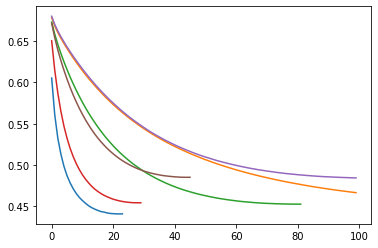

In [228]:
# No preprocessing
# Raw counts
print('No prep, raw counts')
run_logistic(dftrain_minimal_noprep, 0.2, 100)
# Normalized
print('No prep, normalized')
run_logistic(dftrain_min_norm_noprep, 0.2, 100)
# TF-IDF
print('No prep, TF-IDF')
run_logistic(dftrain_min_tfidf_noprep, 0.2, 100)
# With preprocessing
# Raw counts
print('Preprocessed, raw counts')
run_logistic(dftrain_minimal, 0.2, 100)
# Normalized
print('Preprocessed, normalized')
run_logistic(dftrain_min_norm, 0.2, 100)
# TF-IDF
print('Preprocessed, TF-IDF')
run_logistic(dftrain_min_tfidf, 0.2, 100)
print('Done with Logistic models')

No prep, raw counts
Training...
Train on 5329 samples, validate on 2284 samples
Epoch 1/100
5329/5329 [==============================] - 4s 838us/sample - loss: 0.6536 - val_loss: 0.6145
Epoch 2/100
5329/5329 [==============================] - 1s 170us/sample - loss: 0.5868 - val_loss: 0.5725
Epoch 3/100
5329/5329 [==============================] - 1s 159us/sample - loss: 0.5430 - val_loss: 0.5451
Epoch 4/100
5329/5329 [==============================] - 1s 165us/sample - loss: 0.5108 - val_loss: 0.5258
Epoch 5/100
5329/5329 [==============================] - 1s 160us/sample - loss: 0.4854 - val_loss: 0.5113
Epoch 6/100
5329/5329 [==============================] - 1s 160us/sample - loss: 0.4642 - val_loss: 0.5001
Epoch 7/100
5329/5329 [==============================] - 1s 161us/sample - loss: 0.4463 - val_loss: 0.4913
Epoch 8/100
5329/5329 [==============================] - 1s 152us/sample - loss: 0.4306 - val_loss: 0.4841
Epoch 9/100
5329/5329 [==============================] - 1s 160u

5329/5329 [==============================] - 1s 139us/sample - loss: 0.4817 - val_loss: 0.5162
Epoch 52/100
5329/5329 [==============================] - 1s 139us/sample - loss: 0.4795 - val_loss: 0.5148
Epoch 53/100
5329/5329 [==============================] - 1s 144us/sample - loss: 0.4774 - val_loss: 0.5134
Epoch 54/100
5329/5329 [==============================] - 1s 139us/sample - loss: 0.4753 - val_loss: 0.5121
Epoch 55/100
5329/5329 [==============================] - 1s 134us/sample - loss: 0.4732 - val_loss: 0.5107
Epoch 56/100
5329/5329 [==============================] - 1s 141us/sample - loss: 0.4712 - val_loss: 0.5094
Epoch 57/100
5329/5329 [==============================] - 1s 146us/sample - loss: 0.4692 - val_loss: 0.5082
Epoch 58/100
5329/5329 [==============================] - 1s 151us/sample - loss: 0.4673 - val_loss: 0.5069
Epoch 59/100
5329/5329 [==============================] - 1s 159us/sample - loss: 0.4653 - val_loss: 0.5057
Epoch 60/100
5329/5329 [=================

5329/5329 [==============================] - 1s 136us/sample - loss: 0.4721 - val_loss: 0.5193
Epoch 26/100
5329/5329 [==============================] - 1s 130us/sample - loss: 0.4670 - val_loss: 0.5161
Epoch 27/100
5329/5329 [==============================] - 1s 135us/sample - loss: 0.4620 - val_loss: 0.5130
Epoch 28/100
5329/5329 [==============================] - 1s 138us/sample - loss: 0.4571 - val_loss: 0.5100
Epoch 29/100
5329/5329 [==============================] - 1s 138us/sample - loss: 0.4524 - val_loss: 0.5073
Epoch 30/100
5329/5329 [==============================] - 1s 137us/sample - loss: 0.4478 - val_loss: 0.5046
Epoch 31/100
5329/5329 [==============================] - 1s 136us/sample - loss: 0.4434 - val_loss: 0.5021
Epoch 32/100
5329/5329 [==============================] - 1s 138us/sample - loss: 0.4391 - val_loss: 0.4996
Epoch 33/100
5329/5329 [==============================] - 1s 142us/sample - loss: 0.4350 - val_loss: 0.4973
Epoch 34/100
5329/5329 [=================

5329/5329 [==============================] - 1s 119us/sample - loss: 0.5366 - val_loss: 0.5453
Epoch 8/100
5329/5329 [==============================] - 1s 111us/sample - loss: 0.5239 - val_loss: 0.5354
Epoch 9/100
5329/5329 [==============================] - 1s 112us/sample - loss: 0.5127 - val_loss: 0.5270
Epoch 10/100
5329/5329 [==============================] - 1s 106us/sample - loss: 0.5029 - val_loss: 0.5192
Epoch 11/100
5329/5329 [==============================] - 1s 107us/sample - loss: 0.4941 - val_loss: 0.5127
Epoch 12/100
5329/5329 [==============================] - 1s 122us/sample - loss: 0.4863 - val_loss: 0.5068
Epoch 13/100
5329/5329 [==============================] - 1s 128us/sample - loss: 0.4791 - val_loss: 0.5019
Epoch 14/100
5329/5329 [==============================] - 1s 133us/sample - loss: 0.4727 - val_loss: 0.4972
Epoch 15/100
5329/5329 [==============================] - 1s 130us/sample - loss: 0.4668 - val_loss: 0.4933
Epoch 16/100
5329/5329 [===================

5329/5329 [==============================] - 1s 113us/sample - loss: 0.5141 - val_loss: 0.5369
Epoch 38/100
5329/5329 [==============================] - 1s 100us/sample - loss: 0.5116 - val_loss: 0.5350
Epoch 39/100
5329/5329 [==============================] - 1s 104us/sample - loss: 0.5090 - val_loss: 0.5331
Epoch 40/100
5329/5329 [==============================] - 1s 105us/sample - loss: 0.5066 - val_loss: 0.5314
Epoch 41/100
5329/5329 [==============================] - 1s 113us/sample - loss: 0.5043 - val_loss: 0.5297
Epoch 42/100
5329/5329 [==============================] - 1s 115us/sample - loss: 0.5020 - val_loss: 0.5281
Epoch 43/100
5329/5329 [==============================] - 1s 111us/sample - loss: 0.4997 - val_loss: 0.5265
Epoch 44/100
5329/5329 [==============================] - 1s 127us/sample - loss: 0.4975 - val_loss: 0.5250
Epoch 45/100
5329/5329 [==============================] - 1s 126us/sample - loss: 0.4954 - val_loss: 0.5235
Epoch 46/100
5329/5329 [=================

5329/5329 [==============================] - 1s 98us/sample - loss: 0.5568 - val_loss: 0.5672
Epoch 12/100
5329/5329 [==============================] - 1s 96us/sample - loss: 0.5485 - val_loss: 0.5609
Epoch 13/100
5329/5329 [==============================] - 1s 95us/sample - loss: 0.5409 - val_loss: 0.5549
Epoch 14/100
5329/5329 [==============================] - 1s 98us/sample - loss: 0.5337 - val_loss: 0.5495
Epoch 15/100
5329/5329 [==============================] - 1s 102us/sample - loss: 0.5269 - val_loss: 0.5445
Epoch 16/100
5329/5329 [==============================] - 1s 98us/sample - loss: 0.5206 - val_loss: 0.5398
Epoch 17/100
5329/5329 [==============================] - 1s 95us/sample - loss: 0.5147 - val_loss: 0.5354
Epoch 18/100
5329/5329 [==============================] - 1s 98us/sample - loss: 0.5090 - val_loss: 0.5315
Epoch 19/100
5329/5329 [==============================] - 1s 97us/sample - loss: 0.5038 - val_loss: 0.5278
Epoch 20/100
5329/5329 [=========================

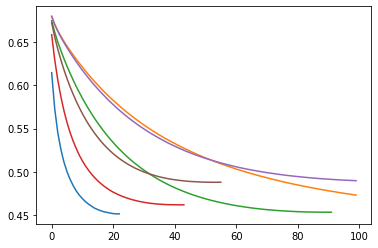

In [35]:
# Document frequency threshold of 5
# No preprocessing
# Raw counts
print('No prep, raw counts')
run_logistic(dftrain_minimal_noprep, 0.3, 100)
# Normalized
print('No prep, normalized')
run_logistic(dftrain_min_norm_noprep, 0.3, 100)
# TF-IDF
print('No prep, TF-IDF')
run_logistic(dftrain_min_tfidf_noprep, 0.3, 100)
# With preprocessing
# Raw counts
print('Preprocessed, raw counts')
run_logistic(dftrain_minimal, 0.3, 100)
# Normalized
print('Preprocessed, normalized')
run_logistic(dftrain_min_norm, 0.3, 100)
# TF-IDF
print('Preprocessed, TF-IDF')
run_logistic(dftrain_min_tfidf, 0.3, 100)
print('Done with Logistic models')

Training...
Train on 6090 samples, validate on 1523 samples
Epoch 1/100
6090/6090 [==============================] - 1s 179us/sample - loss: 0.7582 - val_loss: 0.6808
Epoch 2/100
6090/6090 [==============================] - 1s 140us/sample - loss: 0.6809 - val_loss: 0.6715
Epoch 3/100
6090/6090 [==============================] - 1s 136us/sample - loss: 0.6750 - val_loss: 0.6656
Epoch 4/100
6090/6090 [==============================] - 1s 135us/sample - loss: 0.6713 - val_loss: 0.6617
Epoch 5/100
6090/6090 [==============================] - 1s 130us/sample - loss: 0.6693 - val_loss: 0.6587
Epoch 6/100
6090/6090 [==============================] - 1s 133us/sample - loss: 0.6677 - val_loss: 0.6572
Epoch 7/100
6090/6090 [==============================] - 1s 150us/sample - loss: 0.6668 - val_loss: 0.6553
Epoch 8/100
6090/6090 [==============================] - 1s 130us/sample - loss: 0.6662 - val_loss: 0.6545
Epoch 9/100
6090/6090 [==============================] - 1s 126us/sample - loss: 0.6

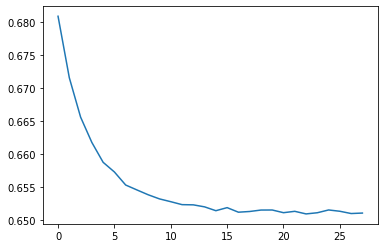

In [110]:
# L1 and L2 regularization both don't help
nn_test = run_logistic(dftrain_minimal_noprep, 0.2, 100, reg='l2', patience=5)

In [113]:
# Regularization may not help that much
np.max(nn_test.get_weights()[0])

0.47307107

In [237]:
def run_neuralNet(dataset, split, epochs, batch_size=32):
    t0 = time.time()
    np.random.seed(1)
    train, test = train_test_split(dataset, test_size=split)
    train_x = np.array(train.drop('_target', axis=1))
    train_y = np.array(train['_target'])
    test_x = np.array(test.drop('_target', axis=1))
    test_y = np.array(test['_target'])
    print('Training...')
    nn = Sequential()
    nn.add(Dense(16, activation='sigmoid', input_shape=(train_x.shape[1],)))
    nn.add(Dense(1, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    #es = EarlyStopping(monitor='val_loss', patience=5)
    h = nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs, validation_data=(test_x, test_y))
    plt.plot(h.history['val_loss'])
    print('Predicting...')
    preds = 1*(nn.predict(test_x) > 0.5)
    cm = confusion_matrix(test_y, preds)
    print(cm)
    tp, fn, fp, tn = cm.ravel()
    accuracy = (tp+tn)/(tp+fn+fp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F = 2*precision*recall/(precision+recall)
    print('Accuracy: {:.2f}%\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF: {:.2f}'.format(100*accuracy, 100*precision, 100*recall, 100*F))
    t1 = time.time()
    print('(Took {:.3f} sec)'.format(t1-t0))
    return nn

Preprocessed, raw counts
Training...
Train on 6090 samples, validate on 1523 samples
Epoch 1/20
6090/6090 [==============================] - 1s 172us/sample - loss: 0.6603 - val_loss: 0.6329
Epoch 2/20
6090/6090 [==============================] - 1s 108us/sample - loss: 0.6022 - val_loss: 0.5823
Epoch 3/20
6090/6090 [==============================] - 1s 108us/sample - loss: 0.5407 - val_loss: 0.5336
Epoch 4/20
6090/6090 [==============================] - 1s 116us/sample - loss: 0.4843 - val_loss: 0.4964
Epoch 5/20
6090/6090 [==============================] - 1s 117us/sample - loss: 0.4401 - val_loss: 0.4731
Epoch 6/20
6090/6090 [==============================] - 1s 113us/sample - loss: 0.4075 - val_loss: 0.4602
Epoch 7/20
6090/6090 [==============================] - 1s 113us/sample - loss: 0.3829 - val_loss: 0.4540
Epoch 8/20
6090/6090 [==============================] - 1s 119us/sample - loss: 0.3638 - val_loss: 0.4523
Epoch 9/20
6090/6090 [==============================] - 1s 127us/sa

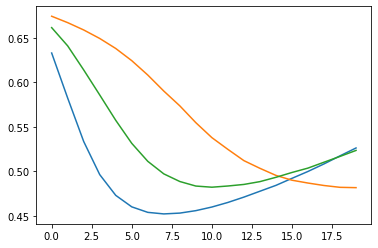

In [238]:
# Neural net models
# Only with preprocessing, otherwise there are too many weights
# Raw counts
print('Preprocessed, raw counts')
run_neuralNet(dftrain_minimal, 0.2, 20)
# Normalized
print('Preprocessed, normalized')
run_neuralNet(dftrain_min_norm, 0.2, 20)
# TF-IDF
print('Preprocessed, TF-IDF')
run_neuralNet(dftrain_min_tfidf, 0.2, 20)
print('Done with Neural Net models')

In [ ]:
# Even at their best validation loss, the deeper NNs don't do as well as simple logistic regression.

In [39]:
# Make submission file

In [37]:
submission = pd.DataFrame(test['id'], columns=['id', 'target'])

In [40]:
def make_random_forest_predictions(trees, train, test):
    print('Training...')
    rft = RandomForestClassifier(n_estimators=trees)
    rft.fit(train.drop('_target', axis=1), train['_target'])
    print('Predicting...')
    preds = rft.predict(test)
    return preds

In [49]:
submission['target'] = make_random_forest_predictions(500, dftrain_minimal_noprep, dftest_minimal_noprep)

Training...
Predicting...


In [50]:
submission.to_csv('submission_rf_noprep.csv', index=False)
# Score: 79.55%

In [51]:
submission['target'] = make_random_forest_predictions(500, dftrain_min_tfidf, dftest_min_tfidf)

Training...
Predicting...


In [52]:
submission.to_csv('submission_rf_prep.csv', index=False)
# Score: 78.732%

In [56]:
def make_logistic_predictions(epochs, batch_size, train, test):
    print('Training...')
    nn = Sequential()
    nn.add(Dense(1, activation='sigmoid', input_shape=(train.drop('_target', axis=1).shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    nn.fit(np.array(train.drop('_target', axis=1)), np.array(train['_target']), batch_size = batch_size, epochs=epochs)
    print('Predicting...')
    preds = 1*(nn.predict(np.array(test)) > 0.5)
    return preds

In [57]:
submission['target'] = make_logistic_predictions(23, 32, dftrain_minimal_noprep, dftest_minimal_noprep)

Training...
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 172us/sample - loss: 0.6369
Epoch 2/23
7613/7613 [==============================] - 1s 129us/sample - loss: 0.5614
Epoch 3/23
7613/7613 [==============================] - 1s 121us/sample - loss: 0.5168
Epoch 4/23
7613/7613 [==============================] - 1s 116us/sample - loss: 0.4853
Epoch 5/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.4610
Epoch 6/23
7613/7613 [==============================] - 1s 104us/sample - loss: 0.4410
Epoch 7/23
7613/7613 [==============================] - 1s 107us/sample - loss: 0.4244
Epoch 8/23
7613/7613 [==============================] - 1s 114us/sample - loss: 0.4100
Epoch 9/23
7613/7613 [==============================] - 1s 108us/sample - loss: 0.3972
Epoch 10/23
7613/7613 [==============================] - 1s 109us/sample - loss: 0.3858
Epoch 11/23
7613/7613 [==============================] - 1s 110us/sample - loss: 0.3756
Epoch 1

In [58]:
submission.to_csv('submission_lg_noprep.csv', index=False)
# Score: 80.98%

In [59]:
submission['target'] = make_logistic_predictions(46, 32, dftrain_min_tfidf, dftest_min_tfidf)

Training...
Train on 7613 samples
Epoch 1/46
7613/7613 [==============================] - 1s 135us/sample - loss: 0.6800
Epoch 2/46
7613/7613 [==============================] - 1s 93us/sample - loss: 0.6537
Epoch 3/46
7613/7613 [==============================] - 1s 92us/sample - loss: 0.6320
Epoch 4/46
7613/7613 [==============================] - 1s 95us/sample - loss: 0.6128
Epoch 5/46
7613/7613 [==============================] - 1s 98us/sample - loss: 0.5952
Epoch 6/46
7613/7613 [==============================] - 1s 85us/sample - loss: 0.5791
Epoch 7/46
7613/7613 [==============================] - 1s 78us/sample - loss: 0.5643
Epoch 8/46
7613/7613 [==============================] - 1s 91us/sample - loss: 0.5506
Epoch 9/46
7613/7613 [==============================] - 1s 109us/sample - loss: 0.5379
Epoch 10/46
7613/7613 [==============================] - 1s 123us/sample - loss: 0.5261
Epoch 11/46
7613/7613 [==============================] - 1s 91us/sample - loss: 0.5153
Epoch 12/46
761

In [60]:
submission.to_csv('submission_lg_prep.csv', index=False)
# Score: 78.22%

In [69]:
def train_model(train_x, train_y, batch_size, epochs):
    nn = Sequential()
    nn.add(Dense(1, activation='sigmoid', input_shape=(train_x.shape[1],)))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])
    nn.fit(train_x, train_y, batch_size = batch_size, epochs=epochs)
    return nn

def train_ensemble(n, batch_size, epochs, data_x, data_y):
    #with tf.device('/GPU:0'):
    models = []
    total = data_x.shape[0]
    all_inds = np.arange(data_x.shape[0])
    dist = np.repeat(1, data_x.shape[0])
    for i in range(n):
        train_x = []
        train_y = []
        if i == 0:
            # First run uses all samples
            train_x = data_x
            train_y = data_y
        else:
            # Next runs weight samples more if they came up as errors
            inds = np.random.choice(all_inds, data_x.shape[0], replace=False, p=dist/total)
            train_x = data_x[inds]
            train_y = data_y[inds]
        print('Training model', i)
        # Todo: simple model for debug...
        model = train_model(train_x, train_y, batch_size, epochs)
        print('Making predictions')
        raw_pred = model.predict(train_x) # Batch size has to match for this to work, apparently.
        #print(raw_pred[0:10])
        pred = np.argmax(raw_pred, axis=1)
        #print(pred[0:10])
        errors = np.not_equal(pred, train_y)
        #print(train_y[0:10])
        #print('Model {0} accuracy is {1:.3f}'.format(i, 100*(1-np.sum(errors)/train_y.shape[0])))
        dist += errors
        total += sum(errors)
        models.append(model)
    return models

In [70]:
models = train_ensemble(25, 32, 23, np.array(dftrain_minimal.drop('_target', axis=1)), np.array(dftrain_minimal['_target']))

Training model 0
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 148us/sample - loss: 0.6645
Epoch 2/23
7613/7613 [==============================] - 1s 101us/sample - loss: 0.6065
Epoch 3/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.5626
Epoch 4/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.5285
Epoch 5/23
7613/7613 [==============================] - 1s 113us/sample - loss: 0.5013
Epoch 6/23
7613/7613 [==============================] - 1s 98us/sample - loss: 0.4790
Epoch 7/23
7613/7613 [==============================] - 1s 97us/sample - loss: 0.4602
Epoch 8/23
7613/7613 [==============================] - 1s 97us/sample - loss: 0.4442
Epoch 9/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.4304
Epoch 10/23
7613/7613 [==============================] - 1s 109us/sample - loss: 0.4182
Epoch 11/23
7613/7613 [==============================] - 1s 116us/sample - loss: 0.4074
Epoch

Epoch 23/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.3287
Making predictions
Training model 4
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 131us/sample - loss: 0.6621
Epoch 2/23
7613/7613 [==============================] - 1s 115us/sample - loss: 0.6044
Epoch 3/23
7613/7613 [==============================] - 1s 127us/sample - loss: 0.5608
Epoch 4/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.5270
Epoch 5/23
7613/7613 [==============================] - 1s 95us/sample - loss: 0.5000
Epoch 6/23
7613/7613 [==============================] - 1s 101us/sample - loss: 0.4779
Epoch 7/23
7613/7613 [==============================] - 1s 94us/sample - loss: 0.4593
Epoch 8/23
7613/7613 [==============================] - 1s 95us/sample - loss: 0.4434
Epoch 9/23
7613/7613 [==============================] - 1s 98us/sample - loss: 0.4297
Epoch 10/23
7613/7613 [==============================] - 1s 98us/sample - l

7613/7613 [==============================] - 1s 101us/sample - loss: 0.3333
Epoch 23/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.3287
Making predictions
Training model 8
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 132us/sample - loss: 0.6644
Epoch 2/23
7613/7613 [==============================] - 1s 112us/sample - loss: 0.6065
Epoch 3/23
7613/7613 [==============================] - 1s 120us/sample - loss: 0.5624
Epoch 4/23
7613/7613 [==============================] - 1s 105us/sample - loss: 0.5284
Epoch 5/23
7613/7613 [==============================] - 1s 123us/sample - loss: 0.5012
Epoch 6/23
7613/7613 [==============================] - 1s 103us/sample - loss: 0.4789
Epoch 7/23
7613/7613 [==============================] - 1s 115us/sample - loss: 0.4603
Epoch 8/23
7613/7613 [==============================] - 1s 128us/sample - loss: 0.4443
Epoch 9/23
7613/7613 [==============================] - 1s 145us/sample - loss: 0.

7613/7613 [==============================] - 1s 97us/sample - loss: 0.3380
Epoch 22/23
7613/7613 [==============================] - 1s 96us/sample - loss: 0.3333
Epoch 23/23
7613/7613 [==============================] - 1s 95us/sample - loss: 0.3287
Making predictions
Training model 12
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 129us/sample - loss: 0.6647
Epoch 2/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.6062
Epoch 3/23
7613/7613 [==============================] - 1s 98us/sample - loss: 0.5622
Epoch 4/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.5282
Epoch 5/23
7613/7613 [==============================] - 1s 97us/sample - loss: 0.5010
Epoch 6/23
7613/7613 [==============================] - 1s 97us/sample - loss: 0.4788
Epoch 7/23
7613/7613 [==============================] - 1s 98us/sample - loss: 0.4602
Epoch 8/23
7613/7613 [==============================] - 1s 98us/sample - loss: 0.4441
Ep

7613/7613 [==============================] - 1s 102us/sample - loss: 0.3432
Epoch 21/23
7613/7613 [==============================] - 1s 112us/sample - loss: 0.3382
Epoch 22/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.3334
Epoch 23/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.3289
Making predictions
Training model 16
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 130us/sample - loss: 0.6646
Epoch 2/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.6064
Epoch 3/23
7613/7613 [==============================] - 1s 103us/sample - loss: 0.5624
Epoch 4/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.5283
Epoch 5/23
7613/7613 [==============================] - 1s 101us/sample - loss: 0.5011
Epoch 6/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.4787
Epoch 7/23
7613/7613 [==============================] - 1s 102us/sample - loss: 

Epoch 19/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.3485
Epoch 20/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.3433
Epoch 21/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.3383
Epoch 22/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.3335
Epoch 23/23
7613/7613 [==============================] - 1s 102us/sample - loss: 0.3290
Making predictions
Training model 20
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 129us/sample - loss: 0.6622
Epoch 2/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.6042
Epoch 3/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.5606
Epoch 4/23
7613/7613 [==============================] - 1s 101us/sample - loss: 0.5268
Epoch 5/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.4999
Epoch 6/23
7613/7613 [==============================] - 1s 101us/sampl

7613/7613 [==============================] - 1s 99us/sample - loss: 0.3598
Epoch 18/23
7613/7613 [==============================] - 1s 109us/sample - loss: 0.3538
Epoch 19/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.3481
Epoch 20/23
7613/7613 [==============================] - 1s 103us/sample - loss: 0.3429s - 
Epoch 21/23
7613/7613 [==============================] - 1s 106us/sample - loss: 0.3379
Epoch 22/23
7613/7613 [==============================] - 1s 111us/sample - loss: 0.3331
Epoch 23/23
7613/7613 [==============================] - 1s 108us/sample - loss: 0.3287
Making predictions
Training model 24
Train on 7613 samples
Epoch 1/23
7613/7613 [==============================] - 1s 130us/sample - loss: 0.6637
Epoch 2/23
7613/7613 [==============================] - 1s 99us/sample - loss: 0.6057
Epoch 3/23
7613/7613 [==============================] - 1s 100us/sample - loss: 0.5620
Epoch 4/23
7613/7613 [==============================] - 1s 99us/sample - l

In [78]:
# Make test predictions
raw_preds = np.zeros((dftest_minimal.shape[0],1))
for i in range(len(models)):
    print('Making prediction', i)
    raw_preds += models[i].predict(dftest_minimal)
raw_preds /= 25
preds = 1*(raw_preds >= 0.5)
print('Prediction complete')

Making prediction 0
Making prediction 1
Making prediction 2
Making prediction 3
Making prediction 4
Making prediction 5
Making prediction 6
Making prediction 7
Making prediction 8
Making prediction 9
Making prediction 10
Making prediction 11
Making prediction 12
Making prediction 13
Making prediction 14
Making prediction 15
Making prediction 16
Making prediction 17
Making prediction 18
Making prediction 19
Making prediction 20
Making prediction 21
Making prediction 22
Making prediction 23
Making prediction 24
Prediction complete


In [86]:
models[0].weights #oops

[<tf.Variable 'dense_13/kernel:0' shape=(4978, 1) dtype=float32, numpy=
 array([[ 0.30265155],
        [-0.2717932 ],
        [ 0.15796638],
        ...,
        [-0.25512946],
        [-0.37080908],
        [-0.49133685]], dtype=float32)>,
 <tf.Variable 'dense_13/bias:0' shape=(1,) dtype=float32, numpy=array([-0.7828687], dtype=float32)>]

In [82]:
submission['target'] = preds
submission.to_csv('submission_lg_noprep_ensemble.csv', index=False)
# Score: 80.57%